**Importación de librerías**

In [63]:
import os
import pandas as pd
import numpy as np
import cv2
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
import matplotlib.pyplot as plt

**Cargar el dataset**

In [64]:
# Ruta de la carpeta con las imágenes
images_folder='C:/Users/dapar/Desktop/im'

# Cargar datos desde el archivo Excel
data = pd.read_excel('X:/Archivos/Documentos/Trabajo/UTPL/Investigación control de disturbios/Código Python/Seguidor de línea CNN/Datos CNN/data.xlsx')

# Crear una lista para almacenar las imágenes como matrices NumPy
imagenes = []

#cargar imágenes con opencv
for i in range(len(data)):
    image = cv2.imread(images_folder + f'/imagen{i}.jpg')
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imagenes.append(image)

# Crear un dataFrame
df = pd.DataFrame({'Diferencias': data['DIFERENCIA']})
df[['X', 'Y']] = data[['X', 'Y']]

**Análisis exploratorio de los datos**

In [65]:
#revisar si coincide el número de datos y de imágenes
print(len(data),len(imagenes))

7918 7918


In [66]:
#revisar brevemente el dataset
df.head

<bound method NDFrame.head of       Diferencias         X         Y
0           -9780 -0.666667  0.166667
1          -16119 -0.666667  0.166667
2          -17181 -0.666667  0.166667
3          -17922 -0.666667  0.166667
4          -16851 -0.666667  0.166667
...           ...       ...       ...
7913        -3321 -0.114309  0.701357
7914        -3093 -0.108147  0.716309
7915        -2634 -0.095260  0.745803
7916        -2082 -0.078752  0.771930
7917        -1083 -0.045095  0.800422

[7918 rows x 3 columns]>

In [67]:
#revisar los tipos de datos del dataset
df.dtypes

Diferencias      int64
X              float64
Y              float64
dtype: object

In [69]:
#comprobar las dimensiones de las imágenes
imagenes[1000].shape

(770, 100)

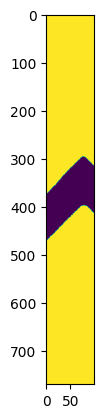

In [70]:
#comprobar las imágenes cargadas
plt.imshow(imagenes[1000])

In [71]:
# número de valores nulos
print(df.isnull().sum().sum())

0


In [72]:
#distribución de variables
df.describe()

,Diferencias,X,Y
count,7918.000000,7918.000000,7918.000000
mean,-295.839859,-0.050645,0.224562
std,17657.553441,0.629432,0.165388
min,-27780.000000,-0.666667,0.166667
25%,-17163.000000,-0.666667,0.166667
50%,-4428.000000,-0.205180,0.166667
75%,18270.000000,0.666667,0.166667
max,43671.000000,0.666667,0.833238


In [76]:
#eliminación de instancias repetidas (misma imagen, mismos datos, para evitar redundancia)

# Encontrar índices de instancias repetidas en base a las columnas Diferencia, X y Y
indices_rep_data = df[df.duplicated(['Diferencias','X', 'Y'])].index

indices_rep = []  # Lista para almacenar los índices de instancias que se repiten

# Comparar imágenes en base a los índices duplicados de datos
for i, idx1 in enumerate(indices_rep_data):
    for idx2 in indices_rep_data[i+1:]:
        if (imagenes[idx1] == imagenes[idx2]).all():
            indices_rep.append(idx1)
            indices_rep.append(idx2)
        
# Se imprime el número de imágenes repetidas
print(len(indices_rep_data))
print(len(indices_rep))
print(indices_rep)

3205
0
[]


Hay 3000 instancias de datos numéricos que se repiten, pero las imágenes de las mismas instancias son distintas entre ellas; por tanto las instancias no son las mismas. No hay datos que deban eliminarse.

In [77]:
#matriz de correlación
df.corr()

,Diferencias,X,Y
Diferencias,1.000000,0.964902,-0.021695
X,0.964902,1.000000,-0.008426
Y,-0.021695,-0.008426,1.000000


La diferencia tiene alta correlación con la variable X y muy baja con la variable Y

**Separación en datos de entrenamiento y datos de prueba**

In [94]:
salidas = df[['X','Y']].values
imagenes=np.asarray(imagenes).astype(np.float32)

# Dividir los datos en conjuntos de entrenamiento y prueba
entradas_train, entradas_test,  salidas_train, salidas_test = train_test_split(imagenes, salidas, test_size=0.2, random_state=42)

# Normalizar las imágenes
entradas_train /= 255
entradas_test /= 255

print("Forma de entradas_train:", entradas_train.shape)
print("Forma de entradas_test:", entradas_test.shape)
print("Forma de salidas_train:", salidas_train.shape)
print("Forma de salidas_test:", salidas_test.shape)

Forma de entradas_train: (6334, 770, 100)
Forma de entradas_test: (1584, 770, 100)
Forma de salidas_train: (6334, 2)
Forma de salidas_test: (1584, 2)


**Creación del modelo de CNN**

In [96]:
# Crear el modelo
model = Sequential()

# Capas convolucionales
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(770, 100, 1)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Capas de pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Capa plana
model.add(Flatten())

# Capas densas
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) #se considera el error cuadrático medio porque se trata de un problema de regresión

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 770, 100, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 385, 50, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 385, 50, 64)       18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 192, 25, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 307200)            0         
                                                                 
 dense_34 (Dense)            (None, 128)             

**Entrenamiento del modelo**

Epoch 1/10
50/50 [==============================] - 229s 5s/step - loss: 24.4840 - accuracy: 0.6238
Epoch 2/10
50/50 [==============================] - 226s 5s/step - loss: 0.0661 - accuracy: 0.9267
Epoch 3/10
50/50 [==============================] - 226s 5s/step - loss: 0.0071 - accuracy: 0.9973
Epoch 4/10
50/50 [==============================] - 222s 4s/step - loss: 0.0034 - accuracy: 0.9975
Epoch 5/10
50/50 [==============================] - 224s 4s/step - loss: 0.0019 - accuracy: 0.9979
Epoch 6/10
50/50 [==============================] - 231s 5s/step - loss: 0.0011 - accuracy: 0.9984
Epoch 7/10
50/50 [==============================] - 275s 5s/step - loss: 7.4069e-04 - accuracy: 0.9987
Epoch 8/10
50/50 [==============================] - 256s 5s/step - loss: 5.4455e-04 - accuracy: 0.9986
Epoch 9/10
50/50 [==============================] - 256s 5s/step - loss: 3.8812e-04 - accuracy: 0.9987
Epoch 10/10
50/50 [==============================] - 252s 5s/step - loss: 2.9218e-04 - accuracy:

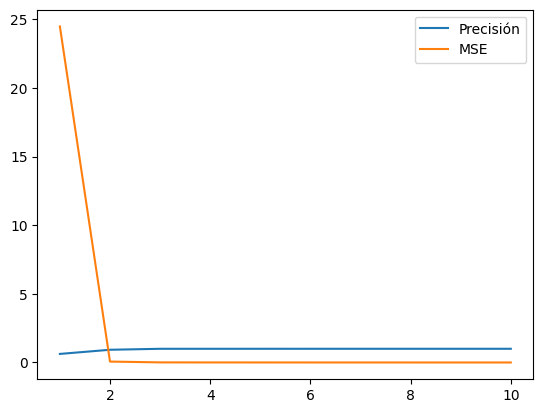

In [97]:
# Entrenar el modelo
history = model.fit(entradas_train, salidas_train, epochs=10, batch_size=128)

# Obtener los datos de precisión y pérdida
precision = history.history['accuracy']
loss = history.history['loss']

# Crear las gráficas
plt.plot(range(1, len(precision) + 1), precision, label='Precisión')
plt.plot(range(1, len(loss) + 1), loss, label='MSE')
plt.legend()
plt.show()

**Evaluación del modelo**

In [98]:
# Evaluar el modelo
score = model.evaluate(entradas_test, salidas_test, verbose=0)
print('MSE:', score[0])
print('Precisión:', score[1])

MSE: 0.0008395278709940612
Precisión: 0.997474730014801


**Exportación del modelo**

In [100]:
# Guardar el modelo entrenado en un archivo h5
model.save('cnn_modelo.keras')